In [1]:
from src.jesterratingdataprocessor import JesterRatingDataProcessor
from src.twohundredkjokesprocessor import TwoHundredKJokesProcessor
import pandas as pd
import matplotlib.pyplot as plt

from transformers import pipeline

In [9]:
jdp = JesterRatingDataProcessor('data/jester/dataset4_jokes.xlsx')
jdp.load_data()
jdp.add_ratings('data/jester/dataset4_ratings.xlsx')
jdp.add_ratings('data/jester/dataset3_ratings.xls')
rating_jokes = jdp.get_data()

Length covering 95% of jokes: 321


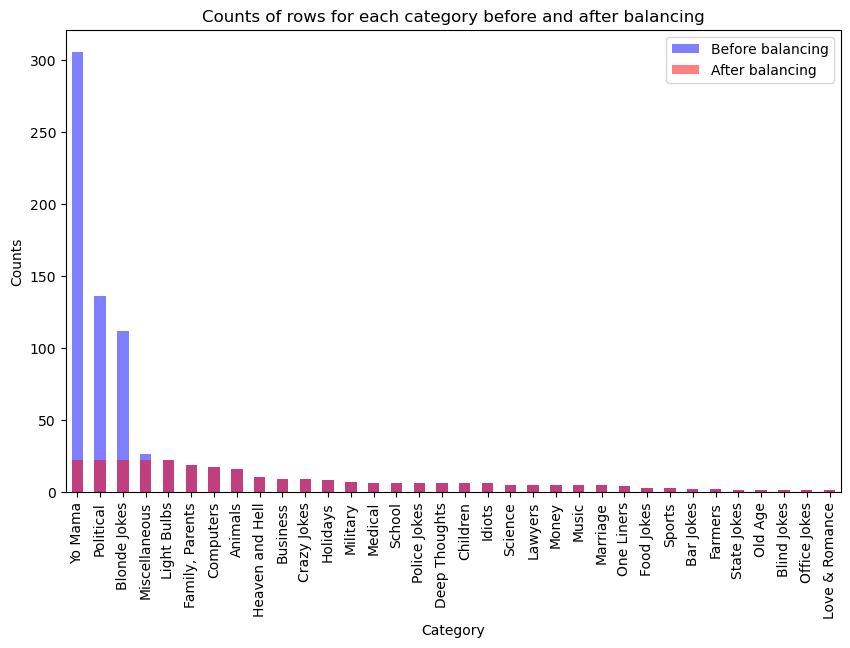

In [2]:
jdp = TwoHundredKJokesProcessor("data/200k/stupidstuff.json")
to_remove = ['Insults', 'Ethnic Jokes', 'Religious', 'Redneck', 'Women', 'Sex', 'Men']
jdp.pipeline(to_remove)
jdp.trim_length()
jdp.balance_categories()
jdp.save("data/200k/data_stupidstuff.csv")

Length covering 95% of jokes: 346


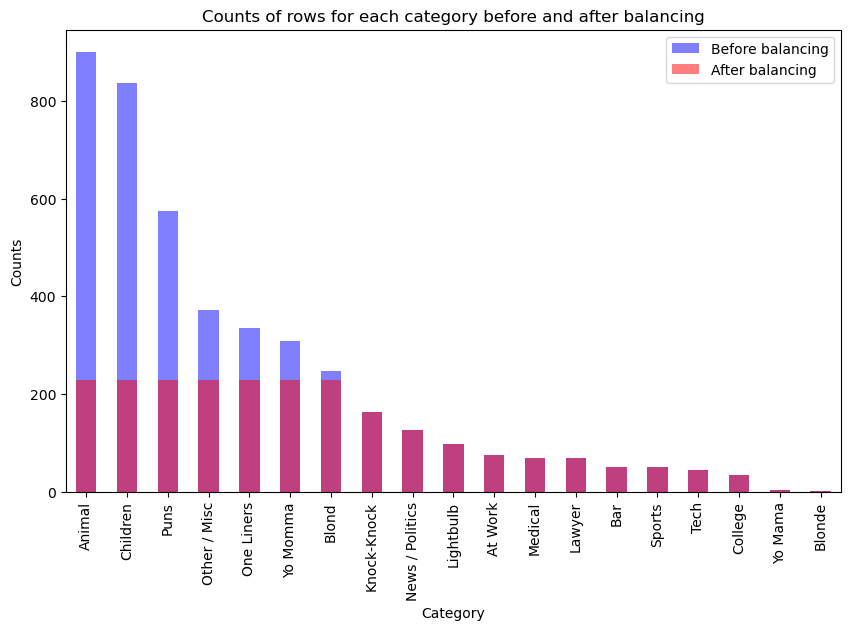

In [3]:
jdp = TwoHundredKJokesProcessor("data/200k/wocka.json")
to_remove = ['Insults', 'Ethnic Jokes', 'Religious', 'Redneck', 'Men / Women', 'Gross']
jdp.pipeline(to_remove)
jdp.trim_length()
jdp.balance_categories()
jdp.save("data/200k/data_wocka.csv")

In [ ]:
from src.jokeraterhelper import JokeRaterHelper

jokerater_helper = JokeRaterHelper()
wocka = pd.read_csv('data/200k/data_wocka.csv')
wocka['Rating'] = wocka['Joke'].apply(lambda text: jokerater_helper.rate_bert_vader(text))

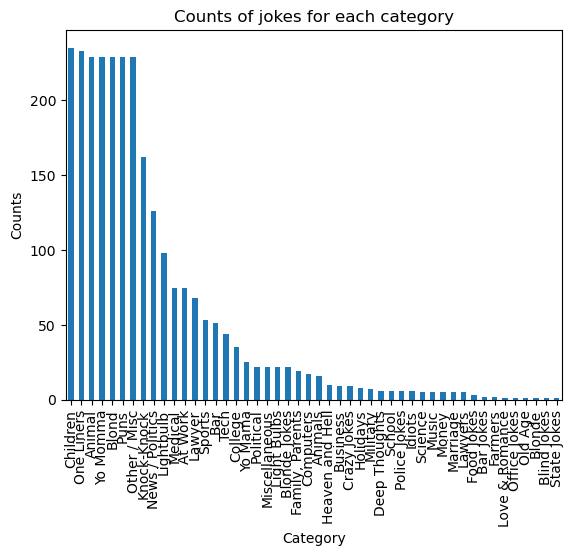

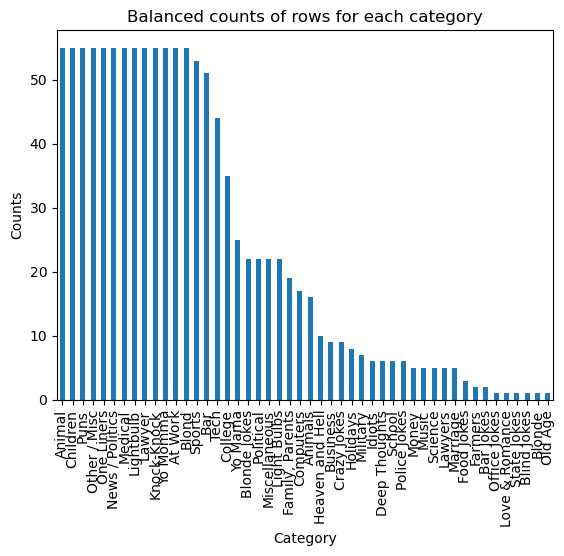

In [6]:
ss = pd.read_csv('data/200k/data_stupidstuff.csv')
wocka_ss = pd.concat([wocka, ss])

# Balance the dataset after concatenation
category_counts = wocka_ss['category'].value_counts()
category_counts.plot(kind='bar')
plt.ylabel('Counts')
plt.xlabel('Category')
plt.title('Counts of jokes for each category')
plt.show()

avg_size = int(category_counts.mean())
lst = [wocka_ss[wocka_ss['category'] == class_index].sample(min(len(group), avg_size), replace=False) 
    for class_index, group in wocka_ss.groupby('category')]
wocka_ss = pd.concat(lst)

# Check the new distribution
balanced_counts = wocka_ss['category'].value_counts()

# You can plot again to visualize
balanced_counts.plot(kind='bar')
plt.ylabel('Counts')
plt.xlabel('Category')
plt.title('Balanced counts of rows for each category')
plt.show()


In [7]:
# Add Seinfeld jokes and save to csv
seinfeld = pd.read_csv('data/seinfeld.csv')
seinfeld['Rating'] = 1
seinfeld['category'] = 'Seinfeld'

# Uniformly resample dataset to generate a total of 100 rows
seinfeld = seinfeld.sample(100, replace=True)

# Merge the datasets to generate a final dataset to be used for joke generation
merged = pd.concat([wocka_ss, seinfeld])
merged.to_csv('data/200k/data_merge.csv')
merged

,Unnamed: 0,Joke,category,Rating
204,6846.0,Confucius say... ~He who value skin does not w...,Animal,0.835000
85,9495.0,What do elephants have that nothing else has? ...,Animal,0.670836
129,3143.0,Q: Why are frogs so happy? A: They eat whateve...,Animal,0.930325
192,5741.0,Why was the baby ant afraid of his uncles? Bec...,Animal,0.650264
66,6399.0,Why did the squirrel sleep on his stomach? To ...,Animal,0.706025
...,...,...,...,...
9,NaN,"My parents didn’t want to move to Florida, but...",Seinfeld,1.000000
9,NaN,"My parents didn’t want to move to Florida, but...",Seinfeld,1.000000
9,NaN,"My parents didn’t want to move to Florida, but...",Seinfeld,1.000000
15,NaN,I once had a leather jacket that got ruined in...,Seinfeld,1.000000


In [7]:
# check all rows have a category
merged = pd.read_csv('data/200k/data_merge.csv')
merged = merged[['Joke', 'Rating', 'category']]

if (len(merged[merged['category'].isna() == True]) > 0 or (merged['category'].map(lambda x: len(x)) == 0).sum() > 0) == True:
    print("At least one row has no category")
else:
    print("All rows have a category value.")

len(merged), merged['category'].nunique()

All rows have a category value.


(1268, 49)

In [14]:
# Load mood classifier

import pickle
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
from transformers import BertForSequenceClassification, BertTokenizer

# Load the model
loaded_model = BertForSequenceClassification.from_pretrained('models/bert_classifier/')

# Load the tokenizer
loaded_tokenizer = BertTokenizer.from_pretrained('models/bert_tokenizer/')

with open('models/bert_label_encoder.pkl', 'rb') as f:
    loaded_le = pickle.load(f)


In [18]:
def get_mood_hf(text):
    classifier = pipeline('sentiment-analysis')
    result = classifier(text)
    return result[0]['label']

def get_mood(text):
    return predict(loaded_model, loaded_tokenizer, text, device, loaded_le)[0]

def predict(model, tokenizer, text, device, label_encoder):
    # ensure the model is in evaluation mode
    model.eval()

    # tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    
    # move the tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # forward pass without computing gradients
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Get the predicted label ID
    predicted_label_id = torch.argmax(outputs.logits, dim=1)

    # return the label corresponding to the predicted ID
    return label_encoder.inverse_transform([predicted_label_id.item()])


In [19]:
get_mood("I am happy")

'love'

In [20]:
merged.loc[:, 'Mood'] = merged['Joke'].apply(lambda text: get_mood(text))
merged

,Joke,Rating,category,Mood
0,Confucius say... ~He who value skin does not w...,0.835000,Animal,hate
1,What do elephants have that nothing else has? ...,0.670836,Animal,surprise
2,Q: Why are frogs so happy? A: They eat whateve...,0.930325,Animal,surprise
3,Why was the baby ant afraid of his uncles? Bec...,0.650264,Animal,hate
4,Why did the squirrel sleep on his stomach? To ...,0.706025,Animal,surprise
...,...,...,...,...
1263,"My parents didn’t want to move to Florida, but...",1.000000,Seinfeld,relief
1264,"My parents didn’t want to move to Florida, but...",1.000000,Seinfeld,relief
1265,"My parents didn’t want to move to Florida, but...",1.000000,Seinfeld,relief
1266,I once had a leather jacket that got ruined in...,1.000000,Seinfeld,hate


In [21]:
merged.to_csv('data/200k/data_merge_moods.csv')

In [10]:
# Merge with the jester ratings dataset: output dataset is used for joke rating only
merged_ratings = pd.concat([merged, rating_jokes])
# Drop category and Index columns not used for rating
merged_ratings = merged_ratings.drop(columns=['category', 'Index'])
# Drop column with index 0
merged_ratings = merged_ratings.drop(merged_ratings.columns[0], axis=1)

merged_ratings.to_csv('data/200k/data_merge_ratings.csv')
merged_ratings

,Joke,Rating
204,Confucius say... ~He who value skin does not w...,0.835000
85,What do elephants have that nothing else has? ...,0.670836
129,Q: Why are frogs so happy? A: They eat whateve...,0.930325
192,Why was the baby ant afraid of his uncles? Bec...,0.650264
66,Why did the squirrel sleep on his stomach? To ...,0.706025
...,...,...
1948250,Q: If a person who speaks three languages is c...,0.803125
1948251,A guy goes into confession and says to the pri...,0.660937
1948252,One Sunday morning William burst into the livi...,0.671875
1948253,A radio conversation of a US naval ship with ...,0.895312
